In [160]:
import pandas as pd

In [161]:
corn = pd.read_excel('commodity_prices.xlsx', sheet_name='C 1 (Corn)')[['Date','Last Price']]
feeder_cattle = pd.read_excel('commodity_prices.xlsx', sheet_name='FC1 (Feeder Cattle)')[['Date','Last Price']]
live_cattle = pd.read_excel('commodity_prices.xlsx', sheet_name='LC1 (Live Cattle)')[['Date','Last Price']]

In [162]:
corn.rename(columns={'Last Price':'Corn'}, inplace=True)
feeder_cattle.rename(columns={'Last Price':'Feeder Cattle'}, inplace=True)
live_cattle.rename(columns={'Last Price':'Live Cattle'}, inplace=True)

In [163]:
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['Corn'] = corn['Corn'].apply(lambda x: converter(x) if ' ' in str(x) else x)

In [164]:
data = pd.merge(corn, feeder_cattle, on='Date', how='inner')
data = pd.merge(data, live_cattle, on='Date', how='inner')

In [165]:
data = data.iloc[::-1]

In [166]:
data['spread'] = data['Live Cattle'] - data['Feeder Cattle']
data['Corn MA'] = data['Corn'].rolling(10).mean()
data['upper'] = data['Corn MA'] + data['Corn'].rolling(10).std()
data['lower'] = data['Corn MA'] - data['Corn'].rolling(10).std()

In [167]:
data['signal'] = 0
data.loc[data['Corn'] > data['upper'], 'signal'] = 1
data.loc[data['Corn'] < data['lower'], 'signal'] = -1
data['signal'] = data['signal'].shift(1)

In [168]:
data['returns'] = data['spread'].pct_change()
data['cumulative returns'] = (data['returns'] + 1).cumprod()
data['signal returns'] = data['returns'] * data['signal']
data['cumulative signal returns'] = (data['signal returns'] + 1).cumprod()

In [169]:
# plot cum returns and signal cum returns with date as x-axis
data = data.iloc[1:]


<AxesSubplot: xlabel='Date'>

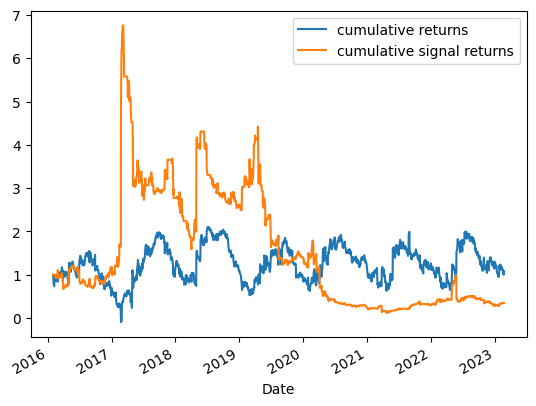

In [170]:
data.plot(x='Date', y=['cumulative returns', 'cumulative signal returns'])